In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/credi-card-transactions/fraudTrain.csv')

# Feature engineering
df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
df['day_of_week'] = pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
df['dob'] = pd.to_datetime(df['dob'])
# Fix for age calculation
df['age'] = (pd.to_datetime('today') - df['dob']).dt.days / 365.25

In [3]:
# Preprocessing
numeric_features = ['amt', 'city_pop', 'age', 'hour', 'day_of_week']
categorical_features = ['category', 'gender', 'state']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X = preprocessor.fit_transform(df.drop(['is_fraud', 'trans_date_trans_time', 'dob', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'zip', 'unix_time', 'merch_lat', 'merch_long'], axis=1))
y = df['is_fraud']


In [4]:
import joblib

# After fitting preprocessor
preprocessor.fit(df.drop(['is_fraud', 'trans_date_trans_time', 'dob', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'zip', 'unix_time', 'merch_lat', 'merch_long'], axis=1))

# Save the preprocessor
joblib.dump(preprocessor, '/content/drive/MyDrive/preprocessor.pkl')


['/content/drive/MyDrive/preprocessor.pkl']

In [ ]:
# Handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Model training
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=8,
    random_state=42
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200,
                       random_state=42)

In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    386466
           1       0.96      0.92      0.94    193660

    accuracy                           0.96    580126
   macro avg       0.96      0.95      0.95    580126
weighted avg       0.96      0.96      0.96    580126


Confusion Matrix:
[[378241   8225]
 [ 15619 178041]]

ROC AUC Score: 0.9490

Accuracy: 0.9588985841006954


In [ ]:
# After fitting Random Forest model
importances = model.feature_importances_

# Get feature names after preprocessing
# This assumes you used a ColumnTransformer named 'preprocessor'
# and you have lists of your original feature names
num_features = ['amt', 'city_pop', 'age', 'hour', 'day_of_week']
cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(['category', 'gender', 'state']))
feature_names = num_features + cat_features

# Pair feature names with their importances
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print the top N important features
print("Top features distinguishing fraudulent transactions:")
for feature, importance in feature_importance[:15]:
    print(f"{feature}: {importance:.4f}")


Top features distinguishing fraudulent transactions:
amt: 0.5378
hour: 0.2233
category_shopping_net: 0.0379
category_grocery_pos: 0.0341
category_home: 0.0177
day_of_week: 0.0135
category_health_fitness: 0.0135
category_misc_net: 0.0130
category_gas_transport: 0.0128
category_kids_pets: 0.0122
age: 0.0113
category_food_dining: 0.0113
city_pop: 0.0072
category_personal_care: 0.0062
category_entertainment: 0.0058


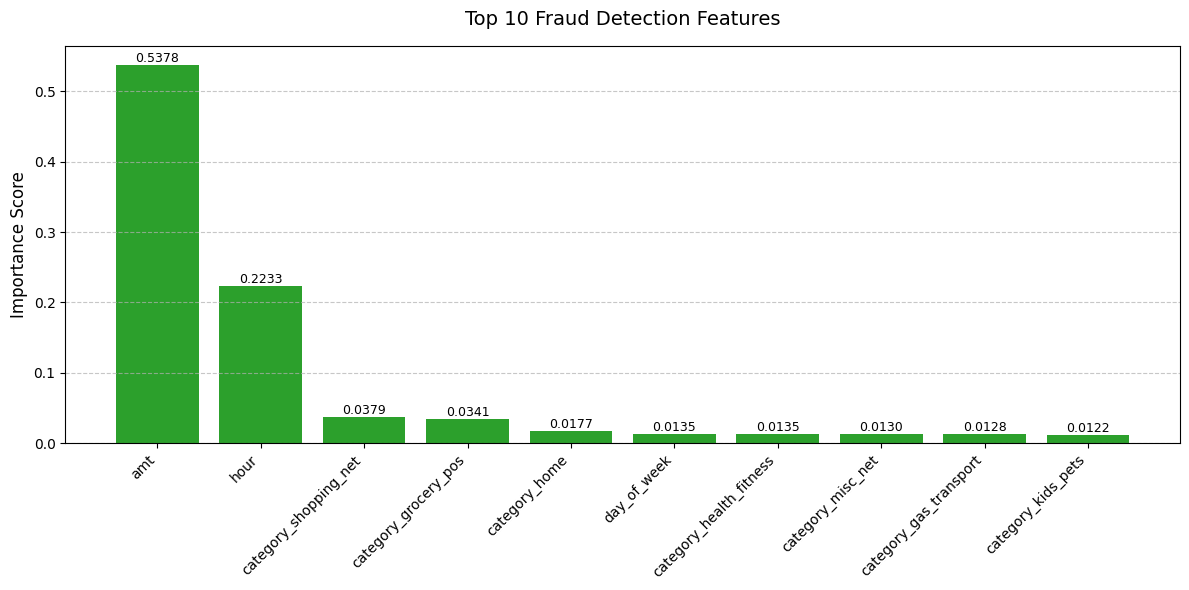

In [ ]:
# Create vertical bar plot
# Sort and select top 10 features
feature_importance = sorted(zip(feature_names, importances),
                           key=lambda x: x[1], reverse=True)[:10]  # Fixed sorting key
features, scores = zip(*feature_importance)

plt.figure(figsize=(12, 6))
bars = plt.bar(features, scores, color='#2ca02c')

# Customize plot
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Importance Score', fontsize=12)
plt.title('Top 10 Fraud Detection Features', fontsize=14, pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:

test_df = pd.read_csv('/content/drive/MyDrive/credi-card-transactions/fraudTest.csv')

# Feature engineering
test_df['hour'] = pd.to_datetime(test_df['trans_date_trans_time']).dt.hour
test_df['day_of_week'] = pd.to_datetime(test_df['trans_date_trans_time']).dt.dayofweek
test_df['dob'] = pd.to_datetime(test_df['dob'])
test_df['age'] = (pd.Timestamp.now() - test_df['dob']).dt.days / 365.25


In [ ]:
# After feature engineering, BEFORE train-test split
test_df_clean = test_df.dropna(subset=['amt', 'age', 'hour', 'category'])

# Now create aligned X_test and y_test
# Use the EXACT SAME columns as in training
X_test = preprocessor.transform(test_df_clean.drop(
    ['is_fraud', 'trans_date_trans_time', 'dob', 'cc_num',
     'merchant', 'first', 'last', 'street', 'city', 'zip',
     'unix_time', 'merch_lat', 'merch_long'], axis=1)
)

y_test = test_df_clean['is_fraud']  # Critical fix


In [ ]:
# Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Test Set Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.13      0.83      0.23      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.90      0.61    555719
weighted avg       1.00      0.98      0.99    555719

ROC AUC: 0.9796

Accuracy: 0.9782408015561822


SHAP values shape: (10000, 72)
Data matrix shape: (10000, 72)


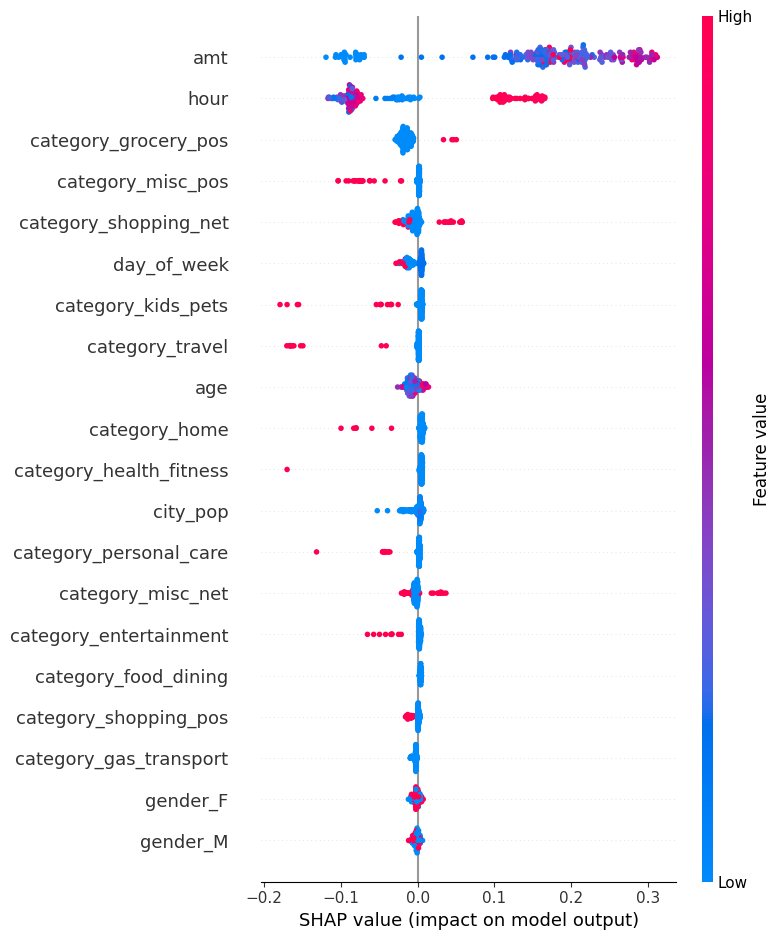

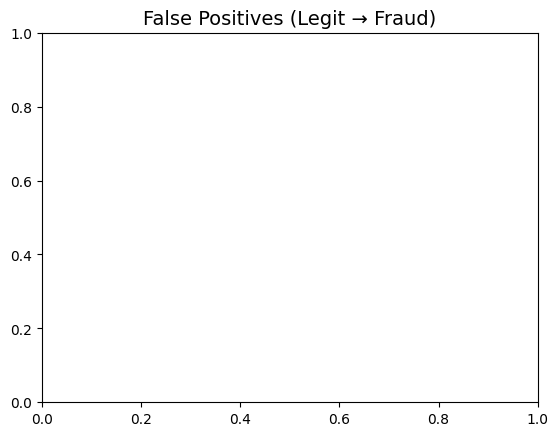

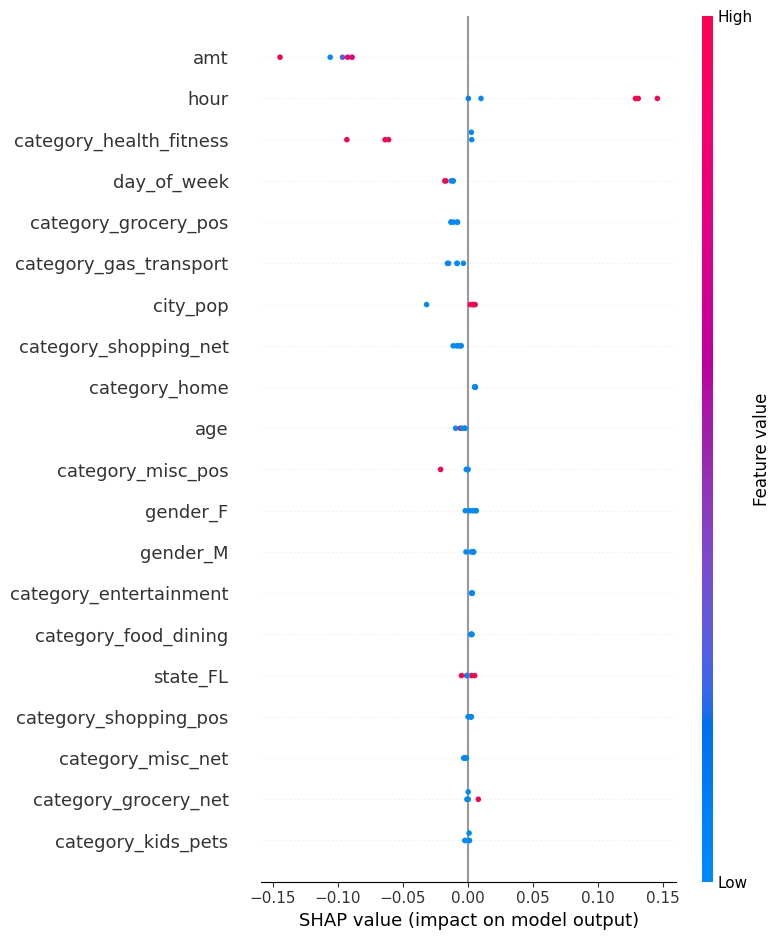

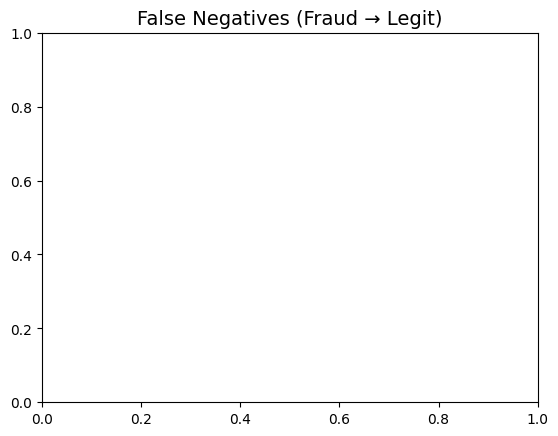

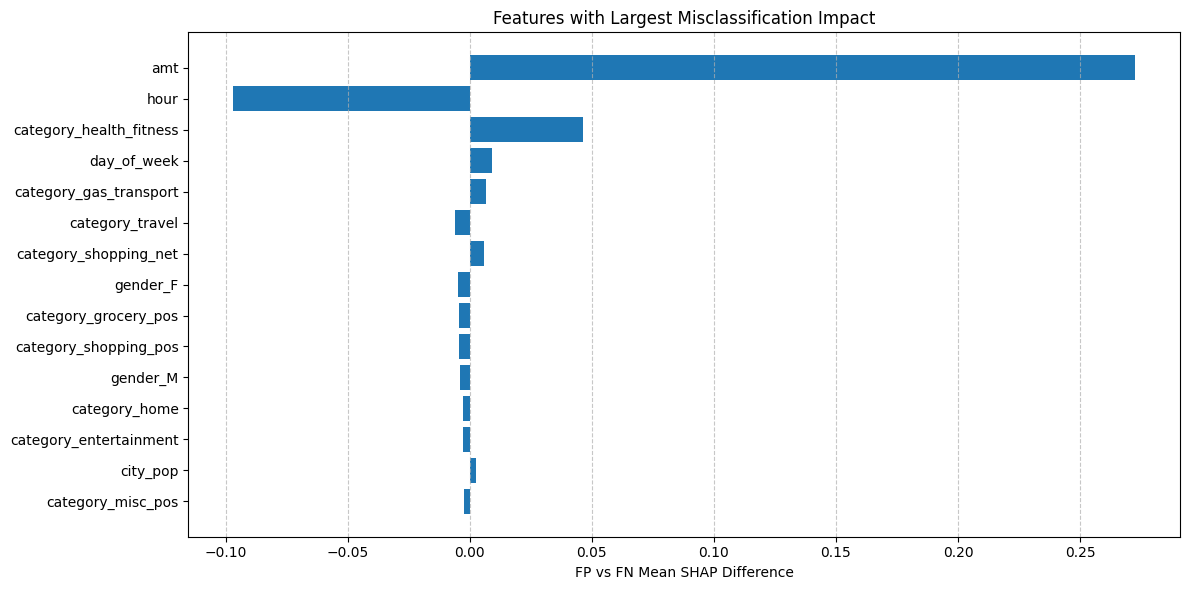

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

# Convert sparse matrix to dense if needed
if issparse(X_test):
    X_test_shap = X_test[:10000].toarray()
else:
    X_test_shap = X_test[:10000]

# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_shap)

# Handle SHAP values based on model type
if isinstance(shap_values, list):
    shap_values_fraud = shap_values[1]
elif shap_values.ndim == 3:
    shap_values_fraud = shap_values[:, :, 1]
else:
    raise ValueError("Unexpected SHAP values structure")

# Verify shapes
print(f"SHAP values shape: {shap_values_fraud.shape}")  # Should be (1000, num_features)
print(f"Data matrix shape: {X_test_shap.shape}")

# Predict and get true labels
y_pred_sample = model.predict(X_test_shap)
y_true_sample = y_test.iloc[:10000].values

fp_mask = (y_pred_sample == 1) & (y_true_sample == 0)
fn_mask = (y_pred_sample == 0) & (y_true_sample == 1)

# 1. Plot FP/FN explanations separately if available
if np.any(fp_mask):
    shap.summary_plot(shap_values_fraud[fp_mask],
                      X_test_shap[fp_mask],
                      feature_names=feature_names,
                      plot_type='dot',
                      show=True)
    plt.title("False Positives (Legit → Fraud)", fontsize=14)
    plt.show()
else:
    print("No False Positives in the selected 10000 samples.")

if np.any(fn_mask):
    shap.summary_plot(shap_values_fraud[fn_mask],
                      X_test_shap[fn_mask],
                      feature_names=feature_names,
                      plot_type='dot',
                      show=True)
    plt.title("False Negatives (Fraud → Legit)", fontsize=14)
    plt.show()
else:
    print("No False Negatives in the selected 10000 samples.")

# 2. Feature difference analysis
if np.any(fp_mask) and np.any(fn_mask):
    fp_feature_means = np.mean(shap_values_fraud[fp_mask], axis=0)
    fn_feature_means = np.mean(shap_values_fraud[fn_mask], axis=0)
    diff_means = fp_feature_means - fn_feature_means

    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(-np.abs(diff_means))[:15]
    plt.barh(np.array(feature_names)[sorted_idx][::-1],
             diff_means[sorted_idx][::-1],
             color='#1f77b4')
    plt.xlabel('FP vs FN Mean SHAP Difference')
    plt.title('Features with Largest Misclassification Impact')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough FP and FN samples to compare feature impact.")


In [ ]:
import joblib

# Save the model
joblib.dump(model, '/content/drive/MyDrive/model.pkl')


['/content/drive/MyDrive/model.pkl']

In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Load model
model = joblib.load('/content/drive/MyDrive/model.pkl')

# Sample new transaction
new_data = pd.DataFrame({
    'trans_date_trans_time': ['21-06-2020 12:14'],
    'cc_num': [2.29116E+15],
    'merchant': ['fraud_Kirlin and Sons'],
    'category': ['personal_care'],
    'amt': [2.86],
    'first': ['Jeff'],
    'last': ['Elliott'],
    'gender': ['M'],
    'street': ['351 Darlene Green'],
    'city': ['Columbia'],
    'state': ['SC'],
    'zip': [29209],
    'lat': [33.9659],
    'long': [-80.9355],
    'city_pop': [333497],
    'job': ['Mechanical engineer'],
    'dob': ['19-03-1968'],
    'trans_num': ['2da90c7d74bd46a0caf3777415b3ebd3'],
    'unix_time': [1371816865],
    'merch_lat': [33.986391],
    'merch_long': [-81.200714]
})

# -----------------------------------
# 🛠 Add missing features (age, hour, day_of_week)

# 1. Calculate 'age'
new_data['dob'] = pd.to_datetime(new_data['dob'], format='%d-%m-%Y')
new_data['trans_date_trans_time'] = pd.to_datetime(new_data['trans_date_trans_time'], format='%d-%m-%Y %H:%M')

new_data['age'] = new_data['trans_date_trans_time'].dt.year - new_data['dob'].dt.year

# 2. Extract 'hour' from transaction time
new_data['hour'] = new_data['trans_date_trans_time'].dt.hour

# 3. Extract 'day_of_week' (Monday=0, Sunday=6)
new_data['day_of_week'] = new_data['trans_date_trans_time'].dt.dayofweek

# -----------------------------------
# 🛠 Now select only the required columns for the model

input_data = new_data[['amt', 'city_pop', 'age', 'hour', 'day_of_week', 'category', 'gender', 'state']]

# Apply the same preprocessing
new_data_processed = preprocessor.transform(input_data)

# Now predict
pred = model.predict(new_data_processed)
print("Prediction (0 = Not Fraud, 1 = Fraud):", pred[0])


Prediction (0 = Not Fraud, 1 = Fraud): 0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Assume you have X_test and y_test
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.13      0.83      0.23      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.90      0.61    555719
weighted avg       1.00      0.98      0.99    555719

ROC AUC Score: 0.9795883120950774
Confusion Matrix:
 [[541850  11724]
 [   368   1777]]
